In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from time import time
import pandas as pd
import os

import os
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from torchsat.models.classification import resnet34, resnet18
import torch.nn as nn
import torch.optim as optim

import rasterio as rio
from rasterio.mask import mask
from rasterio import windows #.from_bounds
from fiona.crs import from_epsg

from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

from glob import glob

In [2]:
class RoofImageDataset_Planet(Dataset):
    """PlanetScope Roof Image Dataset class!"""

    def __init__(self, geo_df, image_dir, imdim=10, transform=None):
        """
        Args:
            geo_df (string): GeoPandas GeoDataFrame containing a 'geometry' column and 'class_code' column. 
                             everything must be in linear dimensions.
            image_dir (string): full path to directory containing multiple Planet images
            imdim (int): image dimension for CNN
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        if not os.path.exists(image_dir):
            raise ValueError(f'{image_dir} does not exist')
        
            
        self.geometries = [p.centroid for p in geo_df.geometry.values]
        self.imdir = image_dir
        self.image_dim = imdim
        self.Y = geo_df.class_code.values
        self.transform = transform
        self.planet_images = glob(f'{self.imdir}/*/*/*_SR.tif')
        
        if len(self.planet_images) < 1:
            raise ValueError(f'{self.imdir} does not contain any images')

    def __len__(self):
        return len(self.geometries)

        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # sample the list of planet images with the specified geometry
        left, bottom, right, top = self.geometries[idx].bounds
        geom = self.geometries[idx]
        
        try:
            sample = self.sample_many_planet_images(geom, self.planet_images)
            cc = self.Y.codes.astype('uint8')[idx]

            assert sample.shape == (4, self.image_dim, self.image_dim), f'array shape is not as specified {sample.shape}'

            if self.transform:
                sample = self.transform(sample)
        
        except Exception as e:
            raise ValueError(e)
            sample = torch.from_numpy(np.zeros((4, int(self.image_dim), int(self.image_dim))))
                
            cc = 255 # highest int8 number
            
        
        # normalize to SR
        sample /= 10000
        
        # convert to tensor
        sample = torch.from_numpy(sample)
        
        return {'image': sample.type(torch.FloatTensor),
                'class_code': torch.tensor(cc).type(torch.LongTensor)}
    
    def sample_many_planet_images(self, geom, planet_files):
    
        # sample the geometry in each image
        samples = []
        left, bottom, right, top = geom.bounds
        for f in planet_files:
            
            # use the windows.from_bounds() method to return the window
            with rio.open(f) as src:
                                
                # Get pixel coordinates from map coordinates
                py, px = src.index(geom.x, geom.y)

                # Build an NxN window
                N = self.image_dim
                window = rio.windows.Window(px - N//2, py - N//2, N, N)
                #print(window)

                # Read the data in the window
                # clip is a nbands * N * N numpy array
                sample = src.read(window=window)
        
                #print(sample.shape)
            
            if sample.shape != (4, self.image_dim, self.image_dim):
                continue
            else:
                samples.append(sample)
            
        # convert to numpy array
        samples_arr = np.array(samples)
        
        #print(samples_arr.shape)

        # check to see if geometry was in none of the images. 
        # If it was, then the sum should be > 0.0, and take the average
        # Else, average should be all zero anyway
        if samples_arr.sum() > 0:
            ans = np.ma.masked_equal(samples_arr, 0).mean(axis=0)
        else:
            ans = samples_arr.mean(axis=0)

        return ans
    
# function to return subset of batch if 255 detected in class labels
def make_good_batch(batch):
    
    '''removes bad sample if 255 detected in class labels
    
    batch: dictionary containing 'image' tensor and 'class_code' tensor
    
    returns: dictionary same as input with class_code==255 removed from class_code 
             and corresponding image tensor removed
    '''
    
    _idx = torch.where(batch['class_code'] != 255)[0]
    
    new_batch={}
    new_batch['image']= batch['image'][_idx]
    new_batch['class_code']= batch['class_code'][_idx]
    
    return new_batch
    

dataframe processing

In [3]:
df_file = '../DC/training-data/ocm_w_ztrax_11001_matched.geojson' 
df = gpd.read_file(df_file)

In [4]:
df = df.to_crs(32618)
df['areaUTM'] = [geom.area for geom in df.geometry]
df['areaUTMsqft'] = [geom.area*10.7639 for geom in df.geometry]

# filter the footprints by distance metric and area mismatch
df = df.loc[(df._distance <= 10) & (df.areaUTMsqft <= df.LotSizeSquareFeet)]

# add the class code categorical variable
df['class_code']=df.RoofCoverStndCode.astype('category') # category type is required for encoding

In [5]:
# first split into train/test for each class
train_df, test_df, val_df = [], [], []

ts = 0.4
vs = 0.2
bad_classes = ['', 'BU', 'OT']
for cl in df.RoofCoverStndCode.unique():
    
    # don't use the '' class
    if cl in bad_classes:
        print(f'skipping {cl} class')
        continue
        
           
    #subset to class
    _df = df.loc[df.RoofCoverStndCode == cl]
    
    # if sample size is small, skip... that sucks
    if _df.shape[0] < 5:
        print(f'class {cl} has shape {_df.shape}...skipping...')
        continue
    
    # get train and test validation arrays. test array is validation array split in half.
    _train, _valtest = train_test_split(_df, random_state=27, test_size=ts)
    train_df.append(_train)
    
    _val, _test = train_test_split(_valtest, random_state=27, test_size=vs)
    test_df.append(_test)
    val_df.append(_val)

skipping BU class
skipping  class
skipping OT class
class CN has shape (4, 86)...skipping...


In [6]:
# concatenate training, validaton, and test dataframes
all_train_df = pd.concat(train_df)
all_train_df = gpd.GeoDataFrame(all_train_df, crs=from_epsg(4326))

all_val_df = pd.concat(val_df)
all_val_df = gpd.GeoDataFrame(all_val_df, crs=from_epsg(4326))

all_test_df = pd.concat(test_df)
all_test_df = gpd.GeoDataFrame(all_test_df, crs=from_epsg(4326))


In [7]:
all_train_df.class_code.unique(), all_val_df.class_code.unique(), all_test_df.class_code.unique()

([CS, ME, SL, UR, TL, WS, SH, WD]
 Categories (8, object): [CS, ME, SL, UR, TL, WS, SH, WD],
 [CS, ME, SL, UR, TL, WS, SH, WD]
 Categories (8, object): [CS, ME, SL, UR, TL, WS, SH, WD],
 [CS, ME, SL, UR, TL, WS, SH, WD]
 Categories (8, object): [CS, ME, SL, UR, TL, WS, SH, WD])

In [8]:
# image file
imfile = '../DC/dc_02222016_10400100185A4600_output_ms_vnir.tif'
imdir = '../DC/planet-data/PSScene4Band-PSSD'
    
# dataset and dataloader
bs = 128
train_ds = RoofImageDataset_Planet(all_train_df[['geometry', 'class_code']], imdir, imdim=224)
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=0)

val_ds = RoofImageDataset_Planet(all_val_df[['geometry', 'class_code']], imdir, imdim=224)
val_loader = DataLoader(val_ds, batch_size=bs, shuffle=True, num_workers=0)

test_ds = RoofImageDataset_Planet(all_test_df[['geometry', 'class_code']], imdir, imdim=224)
test_loader = DataLoader(test_ds, batch_size=bs, shuffle=True, num_workers=0)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
# device=torch.device('cpu')

# model
## seems the errors are thrown when number of classes are == number of channels. Odd!
n_classes = df.RoofCoverStndCode.unique().shape[0] # edit to reflect weird classes?? or keep all?
# n_classes = all_train_df.class_code.unique().shape[0] # this is 8, instead of 12. 1 removed due to small size, other 3 due to being too general
# n_classes = 8
model = resnet18(n_classes, in_channels=4, pretrained=False)
model.to(device)

# make model parallel and on GPU
if torch.cuda.device_count() >= 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    model.to(device)
else:
    #ps_model = nn.DataParallel(ps_model)
    model = nn.DataParallel(model)
    print('made cpu parallel')

# if args.resume:
#     model.load_state_dict(torch.load(args.resume, map_location=device))

# loss
criterion = nn.CrossEntropyLoss()

# optim and lr scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
# lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-8) # for resuming training?
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# writer = SummaryWriter(args.ckp_dir) # need tensorboard

Let's use 4 GPUs!


In [10]:
print_freq=100
losses = []
epoch_loss = []
val_losses = []

num_epochs=20
for epoch in range(num_epochs):
    #writer.add_scalar('train/learning_rate', lr_scheduler.get_lr()[0], epoch)
    print(f'learning rate: {lr_scheduler.get_lr()[0]}, epoch {epoch}')
    
    model.train()
    for idx, batch in enumerate(train_loader):
        
        # account for bad samples
        batch = make_good_batch(batch)
        
        # extract samples
        image,target = batch['image'], batch['class_code']
        image, target = image.to(device), target.to(device)
        
        output = model(image.float()) 
        loss = criterion(output, target.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % print_freq == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, idx * len(image), len(train_loader.dataset), 100. * idx / len(train_loader), loss.item()))
            #writer.add_scalar('train/loss', loss.item(), len(data_loader) * epoch + idx)
            print(f'train/loss {loss.item()} {len(train_loader) * epoch + idx}')
            losses.append((idx, loss.item()))
    
    #train_one_epoch(model, criterion, optimizer, train_loader, device, epoch, args.print_freq, writer)
    
    lr_scheduler.step()
    
    # average loss for the epoch
    epoch_loss.append(np.array(losses)[:,1].mean())
    
    ## need validation dataset
    #evaluate(epoch, model, criterion, val_loader, device, writer)
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for idx, batch in enumerate(val_loader):

            # account for bad samples
            batch = make_good_batch(batch)

            # extract samples
            image,target = batch['image'], batch['class_code']

            image = image.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = model(image)
            val_loss += criterion(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

        val_loss /= len(val_loader.dataset)/val_loader.batch_size

        val_losses.append(val_loss)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss, correct, len(val_loader.dataset),
            100. * correct / len(val_loader.dataset)))
    
    #torch.save(model.state_dict(), os.path.join(args.ckp_dir, "cls_epoch_{}.pth".format(epoch)))

learning rate: 0.001, epoch 0
Train Epoch: 0 [0/47676 (0%)]	Loss: 2.655574
train/loss 2.655573606491089 0
Train Epoch: 0 [12800/47676 (27%)]	Loss: 0.850665
train/loss 0.8506652116775513 100
Train Epoch: 0 [25600/47676 (54%)]	Loss: 0.750864
train/loss 0.7508643865585327 200
Train Epoch: 0 [38400/47676 (80%)]	Loss: 0.740783
train/loss 0.7407829165458679 300

Test set: Average loss: 1.8760, Accuracy: 11465/25428 (45%)

learning rate: 0.001, epoch 1
Train Epoch: 1 [0/47676 (0%)]	Loss: 0.773639
train/loss 0.7736390829086304 373
Train Epoch: 1 [12800/47676 (27%)]	Loss: 0.640580
train/loss 0.6405799388885498 473
Train Epoch: 1 [25600/47676 (54%)]	Loss: 0.515301
train/loss 0.5153011083602905 573
Train Epoch: 1 [38400/47676 (80%)]	Loss: 0.583963
train/loss 0.5839627385139465 673

Test set: Average loss: 0.7514, Accuracy: 19147/25428 (75%)

learning rate: 0.001, epoch 2
Train Epoch: 2 [0/47676 (0%)]	Loss: 0.730551
train/loss 0.7305508255958557 746
Train Epoch: 2 [12800/47676 (27%)]	Loss: 0.73202

Train Epoch: 19 [0/47676 (0%)]	Loss: 0.044677
train/loss 0.044677067548036575 7087
Train Epoch: 19 [12800/47676 (27%)]	Loss: 0.013516
train/loss 0.013516200706362724 7187
Train Epoch: 19 [25600/47676 (54%)]	Loss: 0.025469
train/loss 0.025468530133366585 7287
Train Epoch: 19 [38400/47676 (80%)]	Loss: 0.037730
train/loss 0.037730395793914795 7387

Test set: Average loss: 1.1309, Accuracy: 20597/25428 (81%)



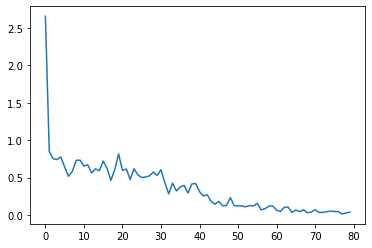

In [11]:
plt.plot(np.array(losses)[:,1])

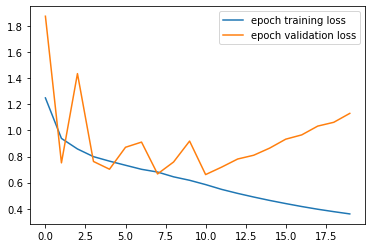

In [12]:
plt.plot(epoch_loss, label='epoch training loss')
plt.plot(val_losses, label='epoch validation loss')
plt.legend()
plt.show()


In [13]:

save_res = True

if save_res:
    # directory
    save_dir = 'files_planet'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # save the model
    step = len(losses)
    model_path = 'dc_planet_ms_ep{}_step{}_b{}.pt'.format(num_epochs, step, bs)
    model_path = os.path.join(save_dir, model_path)
    save = lambda ep: torch.save({
            'model': model.state_dict(),
            'epoch': epoch,
            'step': step,
        }, str(model_path))

    save(model_path)


In [14]:
np.savetxt(os.path.join(save_dir, 'losses_ep{}_step{}_b{}.txt'.format(num_epochs, step, bs)), np.array(losses))
np.savetxt(os.path.join(save_dir, 'epoch_loss_ep{}_step{}_b{}.txt'.format(num_epochs, step, bs)), np.array(epoch_loss))
np.savetxt(os.path.join(save_dir, 'val_losses_ep{}_step{}_b{}.txt'.format(num_epochs, step, bs)), np.array(val_losses))